
## SVHN Model Sensitivity Analysis

In [1]:
import os
import PIL.Image as Image
import matplotlib
import numpy as np
import tensorflow as tf
import random
import gzip
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

### Load compressed pickle files for Train, Validation and Test

In [2]:
pickle_file = './data/SVHN_train1.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train1 = save['X_train1']
  y_train1 = save['y_train1']
  del save

pickle_file = './data/SVHN_train2.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train2 = save['X_train2']
  y_train2 = save['y_train2']
  del save
    
pickle_file = './data/SVHN_train3.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train3 = save['X_train3']
  y_train3 = save['y_train3']
  del save
    
pickle_file = './data/SVHN_train4.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_train4 = save['X_train4']
  y_train4 = save['y_train4']
  del save
    
X_train = np.concatenate(([X_train1, X_train2, X_train3, X_train4]))
y_train = np.concatenate(([y_train1, y_train2, y_train3, y_train4]))

del X_train1, X_train2, X_train3, X_train4
del y_train1, y_train2, y_train3, y_train4

In [3]:
pickle_file = './data/SVHN_valid.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_valid = save['X_valid']
  y_valid = save['y_valid']
  del save
    
pickle_file = './data/SVHN_test.pklz'

with gzip.open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  X_test = save['X_test']
  y_test = save['y_test']
  del save

### Create graph and run model

In [4]:
labels = 11
channels = 1

def run_predict_model(batch_size, image_size, X_data):
    patch_size = 5
    channels1 = 16
    channels2 = 32
    channels3 = 64
    channels4 = 128
    
    shape = [batch_size, image_size, image_size, channels]
    graph = tf.Graph()
    
    with graph.as_default():
        tf_X_data = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, channels))
        
        W1 = tf.get_variable('W1', 
                            shape=[patch_size, patch_size, channels, channels1],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W2 = tf.get_variable('W2', 
                            shape=[patch_size, patch_size, channels1, channels2],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W3 = tf.get_variable('W3', 
                            shape=[patch_size, patch_size, channels2, channels3],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W4 = tf.get_variable('W4', 
                            shape=[patch_size, patch_size, channels3, channels4],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())        
        
        b1 = tf.Variable(tf.constant(1.0, shape=[channels1]), name='b1')
        b2 = tf.Variable(tf.constant(1.0, shape=[channels2]), name='b2')
        b3 = tf.Variable(tf.constant(1.0, shape=[channels3]), name='b3')
        b4 = tf.Variable(tf.constant(1.0, shape=[channels4]), name='b4')
        
        Lw = tf.get_variable('Lw', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw1 = tf.get_variable('Sw1', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw2 = tf.get_variable('Sw2', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw3 = tf.get_variable('Sw3', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw4 = tf.get_variable('Sw4', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw5 = tf.get_variable('Sw5', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
                           
        Lb = tf.Variable(tf.constant(1.0, shape=[labels]), name='Lb')
        Sb1 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb1')
        Sb2 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb2') 
        Sb3 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb3')
        Sb4 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb4')
        Sb5 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb5')
        
        def createModel(data, keep_prob, shape):
            h_conv1 = tf.nn.relu(tf.nn.conv2d(data, W1, [1, 1, 1, 1], 'VALID', name='h_conv1') + b1)
            lrn = tf.nn.local_response_normalization(h_conv1)
            h_drop = tf.nn.dropout(lrn, keep_prob)
            
            h_pool1 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool1')
            h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W2, [1, 1, 1, 1], 'VALID', name='h_conv2') + b2)
            lrn = tf.nn.local_response_normalization(h_conv2)
            h_drop = tf.nn.dropout(lrn, keep_prob)
            
            h_pool2 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool2')
            h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W3, [1, 1, 1, 1], 'VALID', name='h_conv3') + b3)
            h_drop = tf.nn.dropout(h_conv3, keep_prob)

            h_pool3 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool3')
            h_conv4 = tf.nn.relu(tf.nn.conv2d(h_pool3, W4, [1, 1, 1, 1], 'SAME', name='h_conv4') + b4)
            h_drop = tf.nn.dropout(h_conv4, keep_prob)
            
            h_drop_shape = h_drop.get_shape().as_list()
            h_drop = tf.reshape(h_drop, [h_drop_shape[0], h_drop_shape[1] * h_drop_shape[2] * h_drop_shape[3]])
            
            L = tf.matmul(h_drop, Lw) + Lb
            S1 = tf.matmul(h_drop, Sw1) + Sb1
            S2 = tf.matmul(h_drop, Sw2) + Sb2
            S3 = tf.matmul(h_drop, Sw3) + Sb3
            S4 = tf.matmul(h_drop, Sw4) + Sb4
            S5 = tf.matmul(h_drop, Sw5) + Sb5
            
            return [L, S1, S2, S3, S4, S5]
        
        [L, S1, S2, S3, S4, S5] = createModel(tf_X_data, 1.0, shape)

        test_prediction = tf.transpose(tf.argmax(tf.pack([tf.nn.softmax(L), tf.nn.softmax(S1), tf.nn.softmax(S2),
                                    tf.nn.softmax(S3), tf.nn.softmax(S4), tf.nn.softmax(S5)]), 2))
        
        save_model = tf.train.Saver()
        
        with tf.Session(graph=graph) as sess:
            save_model.restore(sess, './data/256_0.9_0.05_50000.ckpt')
            y_data_prediction = sess.run(test_prediction, feed_dict={tf_X_data:X_data[:batch_size, :, :, :], })
    return y_data_prediction

In [33]:
def accuracy(predictions, labels):
    unmatch = 0
    for i in range(labels.shape[0]):
        for j in range(6):
            if (predictions[i][j] != labels[i][j]):
                unmatch += 1
                break
    return (100.0 * (labels.shape[0] - unmatch) / labels.shape[0])

In [44]:
image_size = 32
num_images = 256

train_accuracy = []
for i in range(1000):
    sample = random.sample(range(len(y_train)), 256)
    X_train_sample = X_train[sample]
    y_train_sample = y_train[sample]

    y_train_predicted = run_predict_model(num_images, image_size, X_train_sample)
    train_accuracy.append(accuracy(y_train_predicted, y_train_sample))

print sum(train_accuracy) / float(len(train_accuracy))

84.128515625


In [45]:
valid_accuracy = []
for i in range(1000):
    sample = random.sample(range(len(y_valid)), 256)
    X_valid_sample = X_valid[sample]
    y_valid_sample = y_valid[sample]

    y_valid_predicted = run_predict_model(num_images, image_size, X_valid_sample)
    valid_accuracy.append(accuracy(y_valid_predicted, y_valid_sample))

print sum(valid_accuracy) / float(len(valid_accuracy))

81.076171875


In [46]:
test_accuracy = []
for i in range(10):
    sample = random.sample(range(len(y_test)), 256)
    X_test_sample = X_test[sample]
    y_test_sample = y_test[sample]

    y_test_predicted = run_predict_model(num_images, image_size, X_test_sample)
    test_accuracy.append(accuracy(y_test_predicted, y_test_sample))
    
print sum(test_accuracy) / float(len(test_accuracy))

77.578125


### Display images

In [7]:
num_images = 9

matplotlib.rcParams.update({'font.size': 12})
def display_predicted_dataset(dataset, predicted_labels, labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(330 + i + 1)
        plt.imshow(dataset[i].reshape(image_size, image_size))
        original_str = 'Actual:' + ''.join(map(str, labels[i][1:labels[i][0]+1]))
        predicted_str = '\nPredicted:' + ''.join(map(str, predicted_labels[i][1:predicted_labels[i][0]+1]))
        plt.title(original_str + predicted_str)
        plt.axis('off')
    plt.show()

### Run model on random images from given dataset and display actual and predicted number

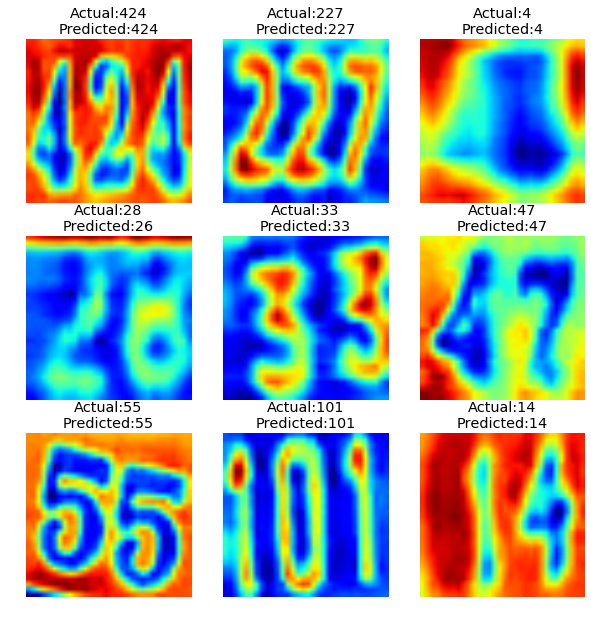

In [50]:
sample = random.sample(range(len(y_train)), num_images)
X_train_sample = X_train[sample]
y_train_sample = y_train[sample]

y_train_predicted = run_predict_model(num_images, image_size, X_train_sample)
display_predicted_dataset(X_train_sample, y_train_predicted, y_train_sample)

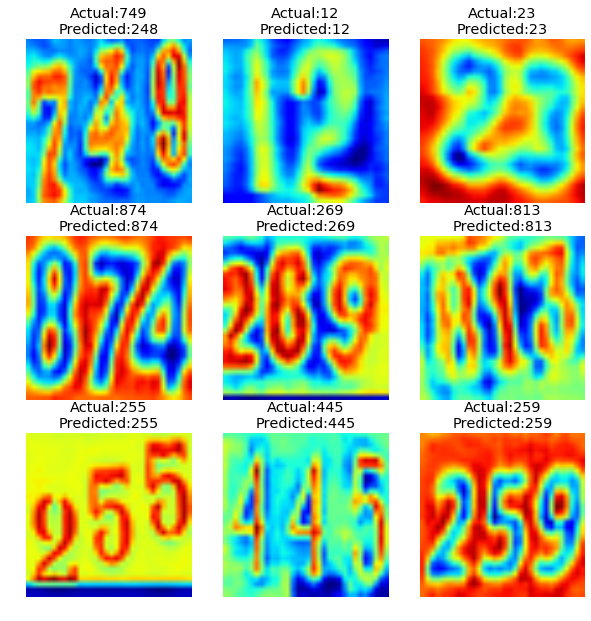

In [51]:
sample = random.sample(range(len(y_valid)), num_images)
X_valid_sample = X_valid[sample]
y_valid_sample = y_valid[sample]

y_valid_predicted = run_predict_model(num_images, image_size, X_valid_sample)
display_predicted_dataset(X_valid_sample, y_valid_predicted, y_valid_sample)

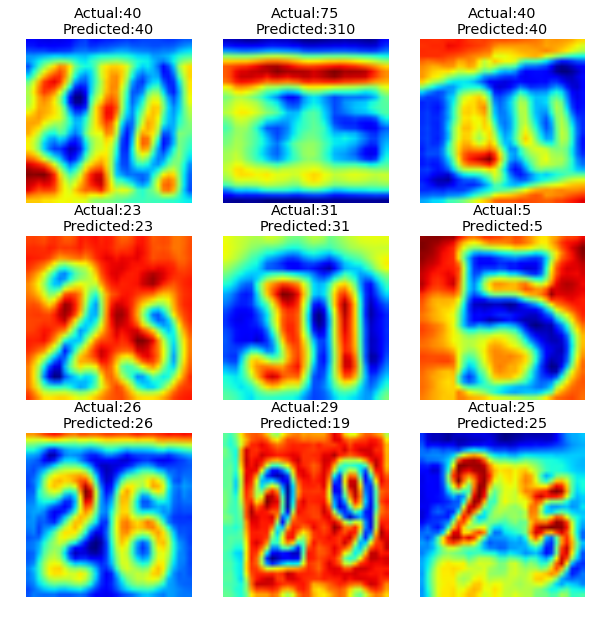

In [52]:
sample = random.sample(range(len(y_test)), num_images)
X_test_sample = X_test[sample]
y_test_sample = y_test[sample]

y_test_predicted = run_predict_model(num_images, image_size, X_test_sample)
display_predicted_dataset(X_test_sample, y_test_predicted, y_test_sample)